In [3]:
!pip install ngram

In [1]:
import numpy as np 
import pandas as pd 
import json
import os

from top2vec.Top2Vec.top2vec import Top2Vec

/home/keen/.pyenv/versions/3.9.13/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-13 10:40:22.087023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760341222.099379 1100177 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760341222.103130 1100177 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760341222.113042 1100177 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than o

In [2]:
import torch
import evaluate
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from nltk.tokenize import sent_tokenize
from tqdm import tqdm, trange
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import tarfile
import ngram

device = "cpu"

accuracy = evaluate.load("accuracy")

model = AutoModelForSequenceClassification.from_pretrained(
    "segm_model/my_model", num_labels=4)

import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
#    return accuracy.compute(predictions=predictions, references=labels)
    return f1.compute(predictions=predictions, references=labels, average='macro')


tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors = 'pt')

training_args = TrainingArguments(
    output_dir="segm_model/my_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    no_cuda=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    #train_dataset=tokenized_ds["train"],
    #eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


def remove_trash(txt_):
    txts = []
    texts = sent_tokenize(txt_)
    for txt in texts:
        tokens = tokenizer(txt, truncation=True)
        predictions = trainer.predict([tokens])
        lbl = np.argmax(predictions.predictions, axis=-1)
        if lbl != 1:
            txts.append(txt)
    return " ".join(txts)        
            
def grab_arxiv_txt(titles):
    titles = {t[:t.find("|")].lower().strip() for t in titles}
    G = ngram.NGram(titles)

    arx_dir = "/data2/arxiv"
    arh = "2030_arxiv_json_dump.tar.gz"

    to_extract = {}
    datas = {}
    cntr202 = 0
    try:
        with tarfile.open(os.path.join(arx_dir, arh), 'r:gz') as tar:
            for member in tqdm(tar):
                if member.isfile():
                    if member.name.endswith(".json"):
                        file_obj = tar.extractfile(member)
                        meta_str = file_obj.read().decode("utf-8")
                        meta = json.loads(meta_str)["meta"]
                        name = member.name[member.name.rfind("/")+1:member.name.rfind(".json")]
                        if "202" in meta:
                            cntr202 += 1
                            title_res = G.search(meta["202"].lower().strip(), threshold=0.7)
                            if len(title_res) > 0:
                                to_extract[name] = title_res[0][0]    
        print(len(to_extract), cntr202)                        
        with tarfile.open(os.path.join(arx_dir, arh), 'r:gz') as tar:
            for member in tqdm(tar):
                if member.isfile():
                    if member.name.endswith(".txt"):     
                        name = member.name[member.name.rfind("/")+1:member.name.rfind(".txt")]
                        if name in to_extract:
                            file_obj = tar.extractfile(member)
                            if file_obj:
                                content = file_obj.read().decode("utf-8")    
                                datas[to_extract[name]] = content
                                        
    except Exception as e:
        print(e)
    return datas

def preprocess_reviews(fname): 
    df = pd.read_excel(fname)
    dat = []
    j = 0
    titles = df["title"].to_list()
    content = grab_arxiv_txt(titles)
    for i, row in df.iterrows():
        text = content.get(row["title"][:row["title"].find("|")].lower().strip(),"")
        text = text.replace("Published as a conference paper at ICLR "," ")    
        text = text.replace("Under review as a conference paper at ICLR "," ").replace("\n"," ")    
        if len(text) < 1:
            text = row["title"][:row["title"].find("|")]
        dat.append([i,row['rate'],row["title"][:row["title"].find("|")],row["title"][:row["title"].find("|")] + " " + remove_trash(row["review"]),text])
        # if j > 100:
        #     break
        j += 1
    return pd.DataFrame(dat,columns=("id","score","title","review","text"))

def getTexts(cell):
    res = []
    for i in range(len(cell)):
        c = cell[i]['content']
        res.append(c[c.find("Summary") + 7:])
    return res    

def preprocess_westlake():
    df = pd.read_json(path_or_buf="train.jsonl", lines=True)
    for i, row in df.iterrows():
        texts = getTexts(row["review_contexts"])
        for t in texts:
            dat.append([i,row["title"] + " " + remove_trash(t)])    

    return pd.DataFrame(dat,columns=("id","text"))    
    

/home/keen/.pyenv/versions/3.9.13/lib/python3.9/site-packages/transformers/training_args.py:1604: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
/tmp/ipykernel_1100177/1618846623.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# ICLR 2017

In [3]:
rews = preprocess_reviews("tp_2017conference.xlsx")

4019617it [57:24, 1167.01it/s]


364 2009790


4019617it [10:30, 6370.90it/s] 


In [4]:
rews.to_csv("filtered_rews.csv",sep=";")

In [3]:
rews = pd.read_csv("filtered_rews.csv",sep=";")

## classification model

## topic model

In [4]:
from top2vec.Top2Vec.top2vec import Top2Vec
Top2Vec

top2vec.top2vec.Top2Vec

In [7]:
topic_model = Top2Vec(documents=rews["text"].to_list(),
                        ngram_vocab=True,
                        contextual_top2vec=True,speed="deep-learn",embedding_model="all-MiniLM-L6-v2",document_ids=rews["id"].to_list(),index_topics=False)



2025-10-03 18:58:24,817 - top2vec - INFO - Pre-processing documents for training
/home/keen/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-10-03 18:58:51,221 - top2vec - INFO - Creating vocabulary embedding
Embedding vocabulary: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [15:10<00:00,  1.20s/it]
2025-10-03 19:14:03,350 - top2vec - INFO - Create contextualized document embeddings
Embedding documents: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:06<00:00,  1.41s/it]
1495it [00:00, 5248.25it/s]
2025-10-03 19:15:10,715 - top2vec - INFO - Creating lower dimension embedding of documents
2025-10-03 19:

topic vectors: (391, 384)


Smoothing document token embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495/1495 [00:08<00:00, 168.78it/s]


(1495, 391)


Calculating document topic distributions: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495/1495 [00:01<00:00, 952.90it/s]


In [5]:
topic_model = Top2Vec.load("topic_modelICLR.dat")

In [6]:
topic_model.get_num_topics()

391

In [27]:
from sklearn.metrics import silhouette_score

vectors = np.array(topic_model.embed(rews["text"].to_list()))

print(vectors.shape)

for topn in [50,100,150,200,250,300]:
    topic_model.hierarchical_topic_reduction(topn)
    tscores,labels = topic_model.search_topics_by_vectors(vectors, 1,reduced=True)
    score = silhouette_score(vectors,labels.flatten())
    print(topn,score,np.unique(labels,return_counts=True)[1].mean())

(1495, 384)


Smoothing document token embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495/1495 [00:08<00:00, 172.11it/s]


(1495, 50)


Calculating document topic distributions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495/1495 [00:01<00:00, 1420.66it/s]


50 0.07593224 34.76744186046512


Smoothing document token embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495/1495 [00:09<00:00, 162.35it/s]


(1495, 100)


Calculating document topic distributions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495/1495 [00:01<00:00, 1279.83it/s]


100 0.1271523 18.012048192771083


Smoothing document token embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495/1495 [00:08<00:00, 175.50it/s]


(1495, 150)


Calculating document topic distributions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495/1495 [00:01<00:00, 1054.37it/s]


150 0.197124 11.240601503759398


Smoothing document token embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495/1495 [00:08<00:00, 168.24it/s]


(1495, 200)


Calculating document topic distributions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495/1495 [00:01<00:00, 1035.51it/s]


200 0.29088053 8.305555555555555


Smoothing document token embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495/1495 [00:08<00:00, 171.84it/s]


(1495, 250)


Calculating document topic distributions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495/1495 [00:01<00:00, 1037.15it/s]


250 0.38559395 6.557017543859649


Smoothing document token embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495/1495 [00:08<00:00, 169.20it/s]


(1495, 300)


Calculating document topic distributions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495/1495 [00:01<00:00, 1046.81it/s]


300 0.4882668 5.4363636363636365


In [28]:
topic_model.hierarchical_topic_reduction(150)

Smoothing document token embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495/1495 [00:08<00:00, 169.13it/s]


(1495, 150)


Calculating document topic distributions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495/1495 [00:01<00:00, 1106.17it/s]


[[5],
 [11],
 [15],
 [17],
 [43],
 [53],
 [68],
 [82],
 [88],
 [89],
 [96],
 [104],
 [114],
 [126],
 [130],
 [144],
 [147],
 [183],
 [185],
 [197],
 [205],
 [217],
 [218],
 [229],
 [236],
 [257],
 [262],
 [265],
 [273],
 [277],
 [291],
 [292],
 [308],
 [311],
 [312],
 [316],
 [318],
 [320],
 [321],
 [322],
 [323],
 [329],
 [330],
 [337],
 [342],
 [344],
 [351],
 [352],
 [353],
 [359],
 [368],
 [369],
 [377],
 [378],
 [388],
 [389],
 [45, 44],
 [62, 382],
 [364, 386],
 [21, 4],
 [246, 294],
 [49, 141],
 [87, 379],
 [164, 163],
 [173, 172],
 [194, 113],
 [199, 189],
 [203, 202],
 [230, 171],
 [270, 271],
 [284, 231],
 [3, 22],
 [7, 30, 93],
 [8, 19],
 [14, 66],
 [57, 58],
 [146, 125],
 [210, 211],
 [290, 33],
 [10, 35],
 [300, 302],
 [370, 343],
 [380, 285],
 [78, 355],
 [142, 247],
 [27, 29],
 [108, 242],
 [131, 103, 102, 77],
 [258, 272],
 [358, 206, 251, 6, 390],
 [34, 266],
 [36, 60],
 [48, 155],
 [59, 67],
 [74, 101],
 [81, 132, 133],
 [139, 84],
 [165, 152],
 [180, 298, 289],
 [201

In [29]:
topic_model.save("topic_modelICLR.dat")

In [30]:
topic_model.get_num_topics(reduced = True)

150

In [31]:
dat = []
topic_words, word_scores, topic_nums = topic_model.get_topics(topic_model.get_num_topics(reduced = True),reduced = True)
for t in range(len(topic_words)):
    dat.append([t,topic_words[t]])

In [32]:
pd.DataFrame(dat, columns=("Id", "Keywords")).to_csv("topicsICLR.csv",sep=";")

In [33]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings('ignore') 
    
from top2vec.Top2Vec.top2vec import Top2Vec

#df = pd.read_excel("tp_2017conference.xlsx")
dat = []
dists = []

top2score = {}
sim_score = {}
for i, row in rews.iterrows():
    _,_,ts,tn = topic_model.query_topics(row["text"], 1,reduced = True)
    score = int(row['score'][row['score'].rfind("#")+1:row["score"].rfind(":")])
    dists.append(ts[0])
    if tn[0] not in top2score:
        top2score[tn[0]] = []
        sim_score[tn[0]] = []
    top2score[tn[0]].append(score)
    sim_score[tn[0]].append(ts[0])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
sorted_topics = sorted([[t,np.asarray(top2score[t]).mean(),len(top2score[t]),np.array(sim_score[t]).mean()] for t in top2score if len(top2score[t]) > 9],key=lambda x: x[1],reverse=True)

In [35]:
sorted_topics

[[144, 7.454545454545454, 11, 0.7397961],
 [136, 7.0, 15, 0.76879436],
 [134, 6.8, 10, 0.69413054],
 [113, 6.777777777777778, 18, 0.69972795],
 [129, 6.75, 12, 0.75632715],
 [109, 6.75, 20, 0.6848767],
 [49, 6.7272727272727275, 11, 0.78610957],
 [148, 6.72, 25, 0.6329854],
 [82, 6.388888888888889, 18, 0.76290375],
 [116, 6.386363636363637, 44, 0.7780798],
 [114, 6.382352941176471, 34, 0.71841496],
 [104, 6.333333333333333, 27, 0.7465005],
 [84, 6.166666666666667, 12, 0.636133],
 [119, 6.104166666666667, 48, 0.7221958],
 [108, 6.090909090909091, 11, 0.737921],
 [140, 6.083333333333333, 24, 0.6926339],
 [138, 6.0, 27, 0.69790804],
 [117, 6.0, 21, 0.6757137],
 [5, 6.0, 13, 0.55931896],
 [137, 5.9375, 16, 0.69190156],
 [131, 5.933333333333334, 15, 0.73855716],
 [107, 5.931034482758621, 29, 0.6991857],
 [96, 5.909090909090909, 11, 0.77144414],
 [128, 5.866666666666666, 15, 0.6779305],
 [48, 5.842105263157895, 19, 0.6686938],
 [41, 5.814814814814815, 27, 0.61393094],
 [130, 5.636363636363637

# Arxiv

In [37]:
import warnings
import pickle
warnings.filterwarnings('ignore') 
    
from top2vec.Top2Vec.top2vec import Top2Vec

arx_dir = "/data2/arxiv"
arh = "2030_arxiv_json_dump/dump/txt"
vecs = "2030_arxiv_json_dump/vectors"
years_dir = "dataset_by_years"

In [26]:
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

import tarfile

statname = "2030_arxiv_y" 
year2id = {}
for year in tqdm(range(2017,2022)):
    name = os.path.join(arx_dir, years_dir,statname + str(year) + ".csv")
    df = pd.read_csv(name,sep=";", header=None)
    year2id[year] = set(df[0].tolist())

progress_stat = {}

print("vectorize..")
for dirpath, dirnames, filenames in os.walk(os.path.join(arx_dir, arh)):
    batch = []
    batch_y = []
    for filename in tqdm(filenames):
        file_path = os.path.join(dirpath, filename)    
        if file_path.endswith(".txt"):
            name = file_path[file_path.rfind("/")+1:file_path.rfind(".txt")]
            
            for y in range(2017,2022):
                if name in year2id[y]:
                    with open(file_path,'r') as file_obj:
                        content = file_obj.read()
                        batch.append(content)
                        batch_y.append(y)
                if len(batch) > 9999:
                    vectors = np.array(topic_model.embed(batch))
                    y2vec = {}
                    for i,y_ in enumerate(batch_y):
                        if y_ not in y2vec:
                            y2vec[y_] = []
                        y2vec[y_].append(vectors[i])   

                    for y_ in y2vec:
                        ydata = np.vstack(y2vec[y_]) 
                        np.save(arx_dir + '/2030_arxiv_json_dump/vectors/' + str(y_) + "/"+ name + '.npy', ydata)    
                    batch_y = []
                    batch = []
                    

if len(batch) > 0:
        vectors = np.array(topic_model.embed(batch))
        y2vec = {}
        for i,y_ in enumerate(batch_y):
            if y_ not in y2vec:
                y2vec[y_] = []
            y2vec[y_].append(vectors[i])   

        for y_ in y2vec:
            ydata = np.vstack(y2vec[y_]) 
            np.save(arx_dir + '/2030_arxiv_json_dump/vectors/' + str(y_) + "/"+ name + '.npy', ydata)    
        batch_y = []
        batch = [] 

   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.96it/s]


vectorize..


0it [00:00, ?it/s]
100%|███████████████████████████████████| 131072/131072 [44:29<00:00, 49.11it/s]


In [38]:
#try:

progress_stat = {}
for dirpath, dirnames, filenames in os.walk(os.path.join(arx_dir, vecs)):
    for filename  in tqdm(filenames):
        file_path = os.path.join(dirpath, filename)    
        if file_path.endswith(".npy"):
            name = file_path[file_path.rfind("/")+1:file_path.rfind(".txt")]
            year = int(dirpath[dirpath.rfind("/")+1:])
            vectors = np.load(file_path)
            vectors = topic_model._l2_normalize(vectors)
           
            tscores,tns = topic_model.search_topics_by_vectors(vectors, 1,reduced=True)
            for tscore, tn in zip(tscores,tns):
                if tscore[0] > 0.6:
                    if not (tn[0] in progress_stat):
                        progress_stat[tn[0]] = {}
                    if year not in progress_stat[tn[0]]:
                        progress_stat[tn[0]][year] = 0
                    progress_stat[tn[0]][year] += 1    

with open("progress_stat2017.pkl", "wb") as file:
    pickle.dump(progress_stat, file)     

0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 61.82it/s]


In [39]:
progress_stat

{132: {2017: 141, 2019: 344, 2021: 386, 2020: 366, 2018: 264},
 117: {2017: 20, 2019: 41, 2021: 53, 2020: 60, 2018: 38},
 125: {2017: 54, 2019: 111, 2021: 94, 2020: 133, 2018: 89},
 124: {2017: 294, 2019: 423, 2021: 485, 2020: 488, 2018: 354},
 141: {2017: 24, 2019: 70, 2021: 95, 2020: 80, 2018: 35},
 90: {2017: 31, 2019: 75, 2021: 54, 2020: 60, 2018: 42},
 105: {2017: 178, 2019: 422, 2021: 507, 2020: 490, 2018: 308},
 98: {2017: 12, 2019: 20, 2021: 30, 2020: 21, 2018: 17},
 72: {2017: 76, 2019: 204, 2021: 196, 2020: 181, 2018: 146},
 56: {2017: 41, 2019: 167, 2021: 311, 2020: 287, 2018: 85},
 146: {2017: 56, 2019: 142, 2021: 192, 2020: 176, 2018: 94},
 34: {2017: 18, 2019: 79, 2021: 96, 2020: 111, 2018: 50},
 116: {2017: 198, 2019: 384, 2021: 409, 2020: 429, 2018: 347},
 76: {2017: 26, 2019: 51, 2021: 49, 2020: 52, 2018: 31},
 87: {2017: 177, 2019: 270, 2021: 338, 2020: 309, 2018: 223},
 44: {2017: 54, 2019: 114, 2021: 111, 2020: 124, 2018: 100},
 65: {2017: 9, 2019: 8, 2021: 12, 2020

In [40]:
import pickle 

with open("ICLR2017_stat.pkl", 'wb') as file:
    pickle.dump(progress_stat, file)


# 10 best

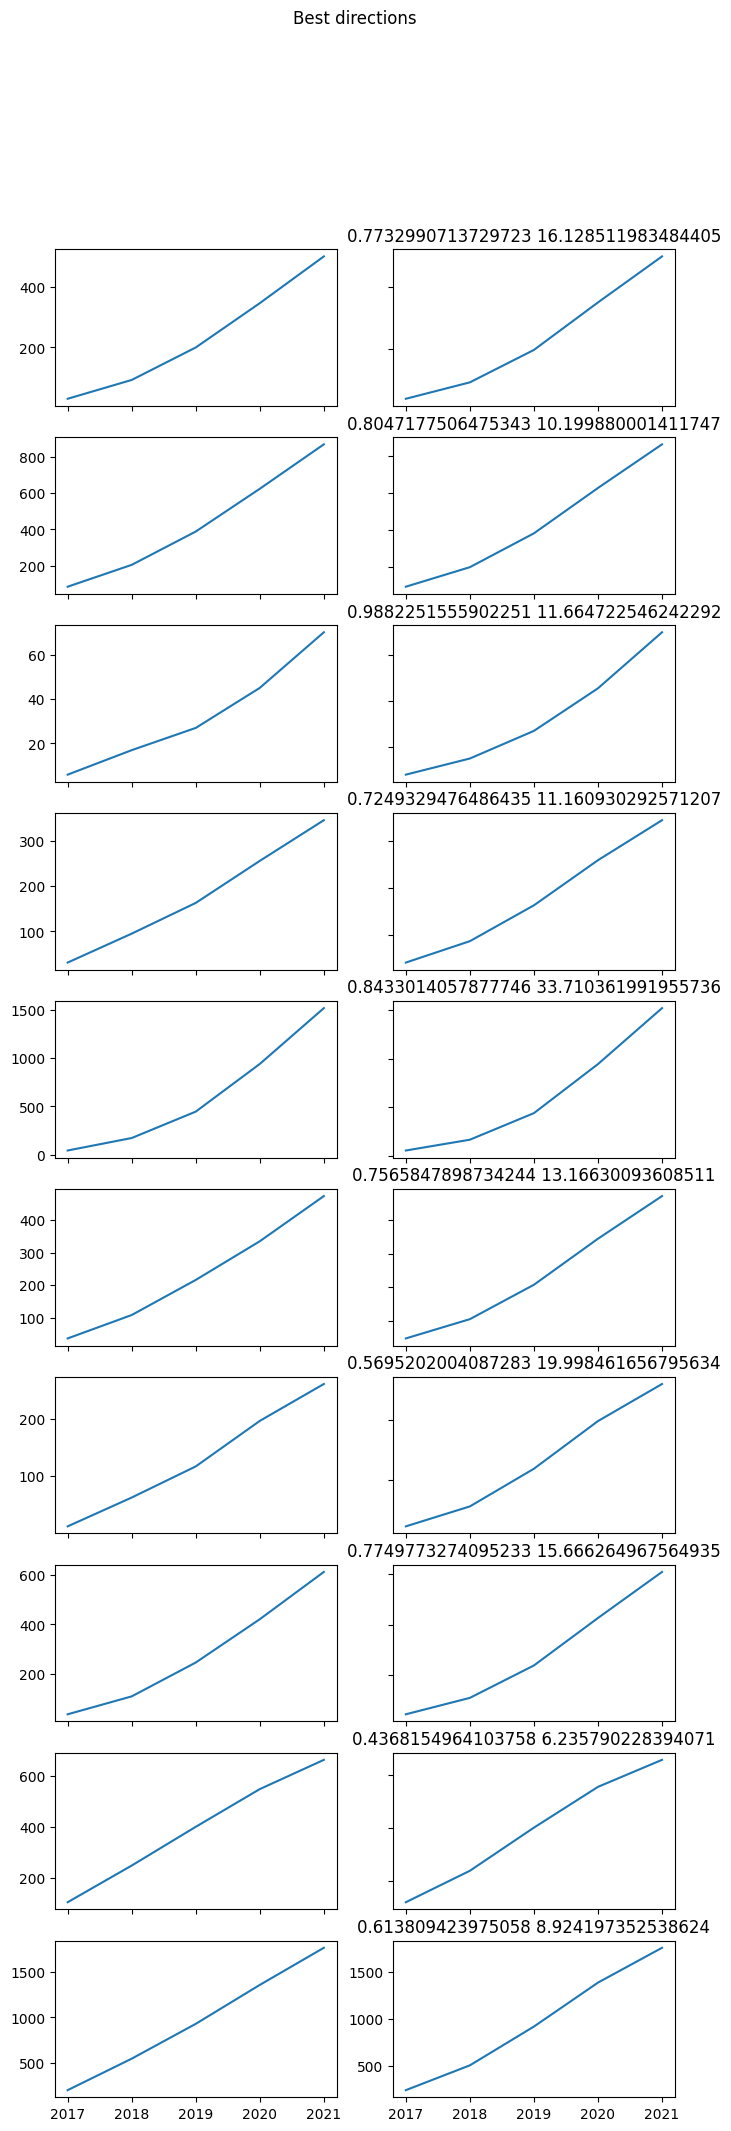

In [41]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

highs = []

for i,t in enumerate(sorted_topics[:10]):
    if t[0] not in progress_stat:    
        progress_stat[t[0]] = {}

    for y in range(2017,2022):
        if y not in progress_stat[t[0]]:
            progress_stat[t[0]][y] = 0

def mu(x, L, x0, k):
    return 4 * np.exp(-k * (x - x0)) / ((1+np.exp(-k * (x - x0)))**2)

fig, axs = plt.subplots(10,2, figsize=(8, 24))
fig.suptitle('Best directions')

def logistic_function(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

for i,t in enumerate(sorted_topics[:10]):
    years, vals = zip(*sorted(progress_stat[t[0]].items(),key=lambda x: x[0]))
    cum_vals = []
    last = 0
    for v in vals:
        last = v + last
        cum_vals.append(last)
    axs[i,0].plot(years, cum_vals)

    initial_guess = [max(cum_vals), np.median(years), 1]
    params, covariance = curve_fit(logistic_function, years, cum_vals, p0=initial_guess)
    L_fit, x0_fit, k_fit = params
    

    def func(L,x0,k):
        s = []
        for j in range(2017,2022):
            s.append(logistic_function(j, L, x0, k))
        return s   
    axs[i,1].plot(years, func(L_fit, x0_fit, k_fit))
    axs[i,1].set_title(str( mu(2021,L_fit, x0_fit, k_fit))+" " + str(float(cum_vals[len(cum_vals) - 1])/(cum_vals[0]+0.001)))
    highs.append(float(cum_vals[len(cum_vals) - 1])/(cum_vals[0]+1))
    if i < 9:
        axs[i,0].label_outer()
        axs[i,1].label_outer()

# 10 worst

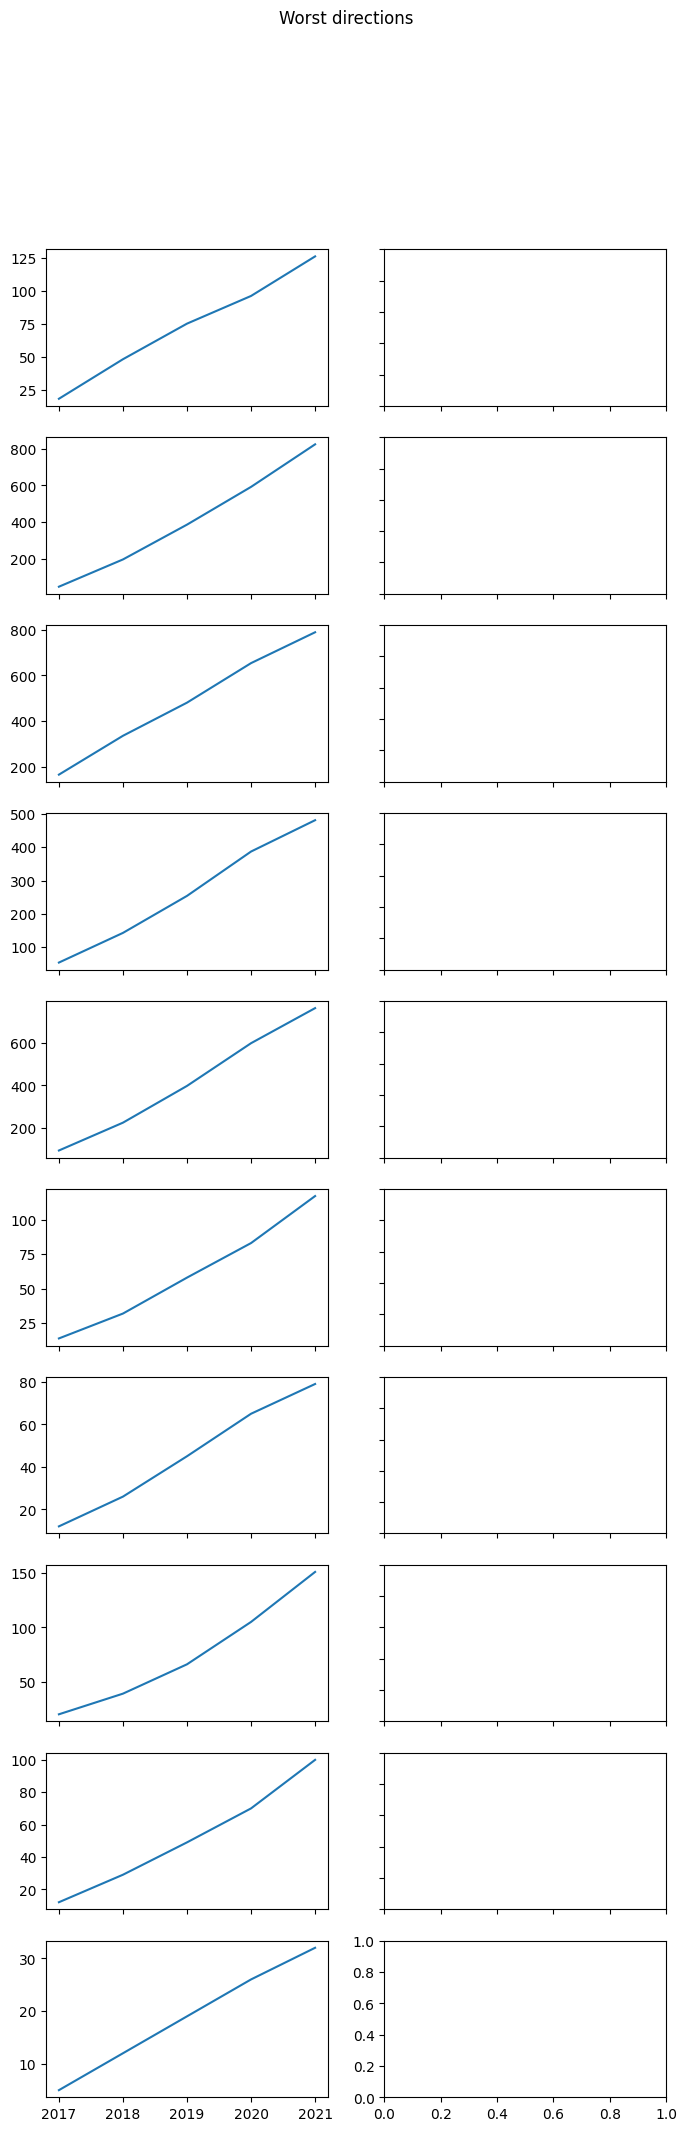

In [42]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(10,2, figsize=(8, 24))
fig.suptitle('Worst directions')

lows = []

def mu(x, L, x0, k):
    return 4 * np.exp(-k * (x - x0)) / ((1+np.exp(-k * (x - x0)))**2)

def logistic_function(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

for i,t in enumerate(sorted_topics[-10:]):
    if t[0] not in progress_stat:    
        progress_stat[t[0]] = {}

    for y in range(2017,2022):
        if y not in progress_stat[t[0]]:
            progress_stat[t[0]][y] = 0

for i,t in enumerate(sorted_topics[-10:]):
    years, vals = zip(*sorted(progress_stat[t[0]].items(),key=lambda x: x[0]))
    cum_vals = []
    last = 0
    for v in vals:
        last = v + last
        cum_vals.append(last)
    axs[i,0].plot(years, cum_vals)

    # initial_guess = [max(cum_vals), np.median(years), 1]
    # params, covariance = curve_fit(logistic_function, years, cum_vals, p0=initial_guess)
    # L_fit, x0_fit, k_fit = params
    

    # def func(L,x0,k):
    #     s = []
    #     for j in range(2017,2022):
    #         s.append(logistic_function(j, L, x0, k))
    #     return s   
    # axs[i,1].plot(years, func(L_fit, x0_fit, k_fit))
    # axs[i,1].set_title(str( mu(2021,L_fit, x0_fit, k_fit)) +" " + str(float(cum_vals[len(cum_vals) - 1])/(cum_vals[0]+0.001)))

    lows.append(float(cum_vals[len(cum_vals) - 1])/(cum_vals[0]+1)) 

    if i < 9:
        axs[i,0].label_outer()
        axs[i,1].label_outer()

In [43]:
from scipy.stats import mannwhitneyu

mannwhitneyu(highs,lows,method="exact")

MannwhitneyuResult(statistic=86.0, pvalue=0.0051960423477451344)

In [44]:
# highs > lows 

In [45]:
mannwhitneyu(highs,lows,method="exact",alternative='greater')

MannwhitneyuResult(statistic=86.0, pvalue=0.0025980211738725672)

In [46]:
highs,lows

([15.625,
  10.081395348837209,
  10.0,
  10.8125,
  32.97826086956522,
  12.81081081081081,
  18.571428571428573,
  15.275,
  6.177570093457944,
  8.879396984924623],
 [6.631578947368421,
  16.137254901960784,
  4.724550898203593,
  8.745454545454546,
  8.042105263157895,
  7.8,
  6.076923076923077,
  7.190476190476191,
  7.6923076923076925,
  5.333333333333333])

# Citation analysis

In [47]:
df = pd.read_excel("2017try.xlsx")

title2cite = {}
for i,row in df.iterrows():
    title = row["title"].lower().strip()
    title2cite[title] = int(row["cite"])

In [48]:
topic2cites = {}
for i,row in rews.iterrows():
    title = row['title'].lower().strip()
    content = row['text']
    _,_,tscore,tn = topic_model.query_topics(content, 1,reduced=True)
    cits = title2cite.get(title, 0) 
    if tn[0] not in topic2cites:
        topic2cites[tn[0]] = []
    topic2cites[tn[0]].append(cits)
    

## 10 best

In [49]:
highs_cite = []

for i,t in enumerate(sorted_topics[:10]):
    top_id = t[0]
    cites = topic2cites[top_id]
    avg_cites = np.asarray(cites).mean()
    highs_cite.append(avg_cites)

## 10 worst

In [50]:
lows_cite = []

for i,t in enumerate(sorted_topics[-10:]):
    top_id = t[0]
    cites = topic2cites[top_id]
    avg_cites = np.asarray(cites).mean()
    lows_cite.append(avg_cites)

In [51]:
highs_cite

[400.90909090909093,
 122.4,
 100.1,
 292.6666666666667,
 937.5,
 78.9,
 343.72727272727275,
 97.04,
 117.16666666666667,
 272.40909090909093]

In [52]:
lows_cite

[32.75,
 94.42857142857143,
 2.6,
 14.666666666666666,
 54.54545454545455,
 27.428571428571427,
 19.25,
 32.25,
 3.5,
 3.857142857142857]

In [132]:
mannwhitneyu(highs_cite,lows_cite,method="exact",alternative='greater')

MannwhitneyuResult(statistic=95.0, pvalue=0.00010283833813245577)

# Get topic scores with the classifier

In [56]:
import torch
import evaluate
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict
import pandas as pd
from transformers import DataCollatorWithPadding
import numpy as np

#encoder = LabelEncoder()
#encoder.fit(dataset['label'])

In [68]:
scores = [int(row['score'][row['score'].rfind("#")+1:row["score"].rfind(":")]) for _,row in rews.iterrows()]
triple_scores = []
for score in scores:
    if score > 6:
        score = "high"
    else:
        if score > 4:
            score = "medium"
        else:
            score = "low"
    triple_scores.append(score)


In [70]:
encoder = LabelEncoder()
encoder.fit(triple_scores)

LabelEncoder()

In [71]:
list(encoder.inverse_transform([0, 1, 2]))

['high', 'low', 'medium']

In [72]:
%load_ext autoreload
%autoreload 2

import warnings
import torch
import evaluate
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict
import pandas as pd
from transformers import DataCollatorWithPadding
import numpy as np


model_name = "roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
device = "cpu"

def preprocess_function(examples):
    return tokenizer([str(e) for e in examples["text"]], truncation=True, max_length=512)

cls_model = AutoModelForSequenceClassification.from_pretrained("review_clf_model2question" + model_name + "/checkpoint-450",num_labels=3)

data_collator = DataCollatorWithPadding(
        tokenizer=tokenizer,
        padding='longest',
        max_length=512,
        pad_to_multiple_of=8,
        return_tensors='pt',
    )

device = "cpu"


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, -1)
#     return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="review_clf_model_without_NEW" + model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01, 
    warmup_ratio=0.15,
    max_grad_norm=1.0,    
    push_to_hub=False,
    no_cuda=True
)

trainer = Trainer(
   model=cls_model,
   args=training_args,
   tokenizer=tokenizer,
   data_collator=data_collator,
)
    

warnings.filterwarnings('ignore') 
    
from top2vec.Top2Vec.top2vec import Top2Vec

df =rews
dat = []
dists = []

top2score = {}
for i, row in df.iterrows():
    _,_,ts,tn = topic_model.query_topics(row["text"], 1,reduced = True)
    txt = row['review']
    qtags = row["review"].count("?")
 
    if qtags > 1:
        txt = "MANY_QUESTIONS" + " " + txt   
    
    tokens = tokenizer(txt, truncation=True)
    predictions = trainer.predict([tokens])
    lbl = np.argmax(predictions.predictions, axis=-1)    
    score = 0
    if lbl == 0:
        score = 2
    if lbl == 2:
        score = 1

    dists.append(ts[0])
    if tn[0] not in top2score:
        top2score[tn[0]] = []
    top2score[tn[0]].append(score)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
sorted_topics2 = sorted([[t,np.asarray(top2score[t]).mean(),len(top2score[t])] for t in top2score if len(top2score[t]) > 9],key=lambda x: x[1],reverse=True)

In [75]:
sorted_topics2

[[28, 1.5833333333333333, 12],
 [136, 1.5, 12],
 [109, 1.4545454545454546, 22],
 [5, 1.375, 16],
 [96, 1.3636363636363635, 11],
 [104, 1.3333333333333333, 27],
 [108, 1.2727272727272727, 11],
 [148, 1.2727272727272727, 11],
 [48, 1.2702702702702702, 37],
 [84, 1.2666666666666666, 15],
 [116, 1.2325581395348837, 43],
 [125, 1.2142857142857142, 14],
 [137, 1.1875, 16],
 [41, 1.1794871794871795, 39],
 [119, 1.1666666666666667, 42],
 [126, 1.1666666666666667, 12],
 [13, 1.0833333333333333, 12],
 [128, 1.0833333333333333, 12],
 [110, 1.0833333333333333, 12],
 [142, 1.08, 25],
 [131, 1.0606060606060606, 33],
 [51, 1.0578512396694215, 121],
 [27, 1.05, 60],
 [56, 1.0, 27],
 [85, 1.0, 10],
 [132, 1.0, 13],
 [80, 0.948, 250],
 [38, 0.9041095890410958, 73],
 [69, 0.9, 10],
 [146, 0.8333333333333334, 12],
 [4, 0.8125, 16],
 [107, 0.8, 15],
 [122, 0.7222222222222222, 18],
 [133, 0.6875, 16],
 [135, 0.6666666666666666, 12],
 [22, 0.5714285714285714, 14]]

# 10 best

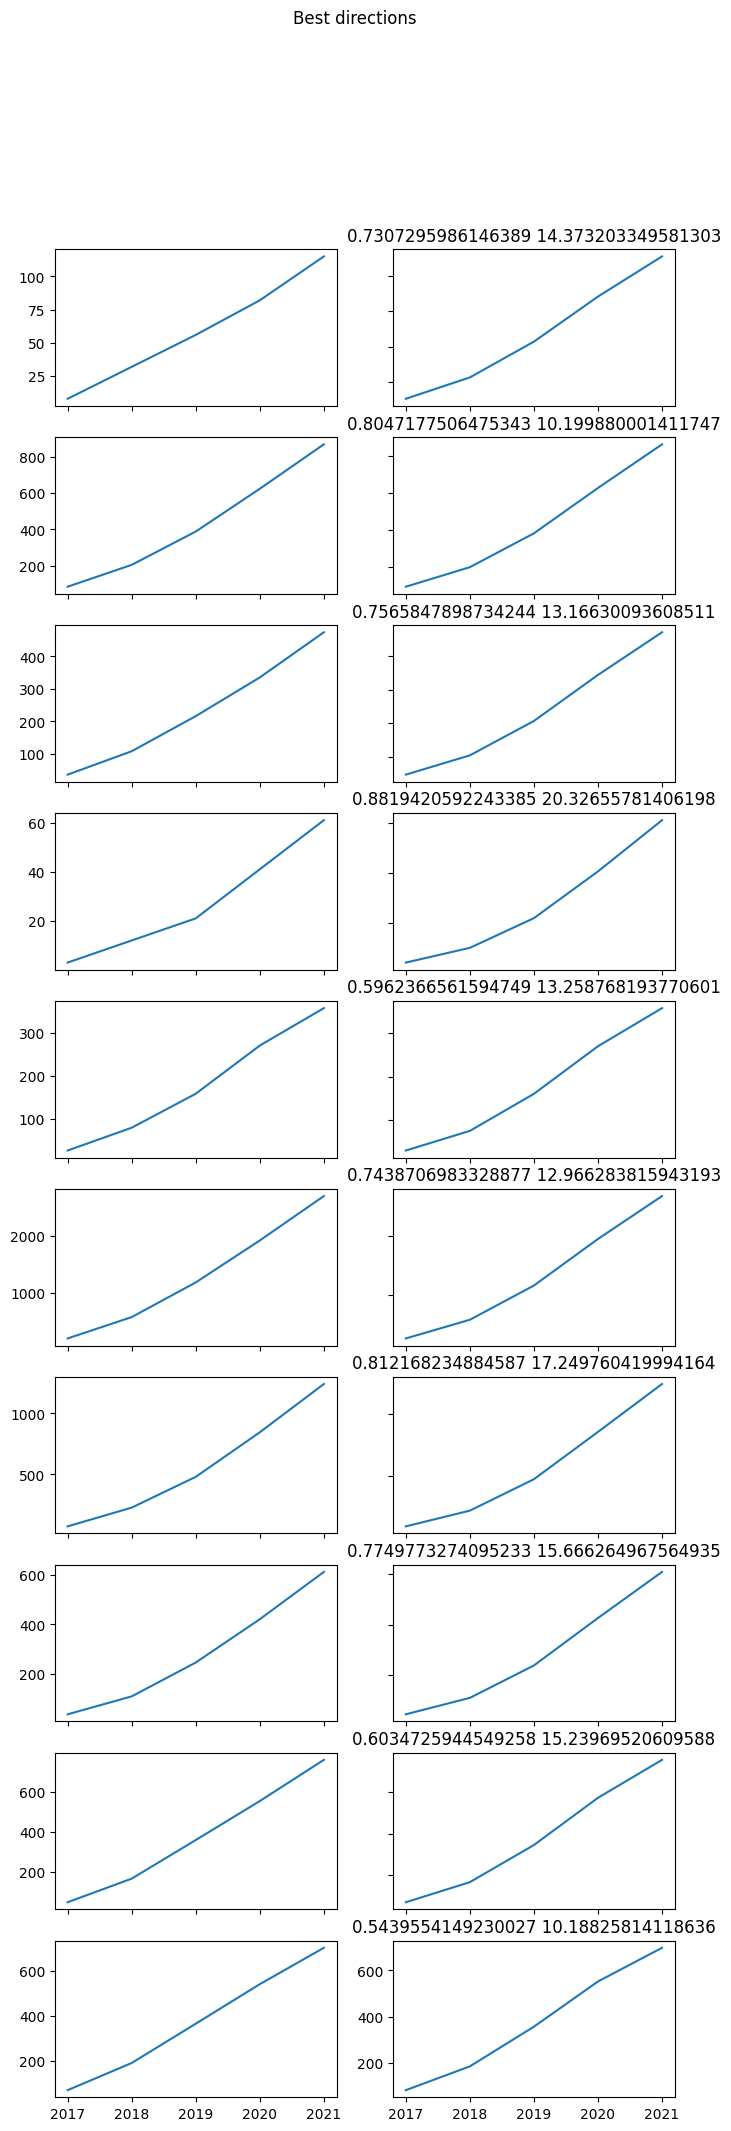

In [76]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

highs = []

for i,t in enumerate(sorted_topics2[:10]):
    if t[0] not in progress_stat:    
        progress_stat[t[0]] = {}

    for y in range(2017,2022):
        if y not in progress_stat[t[0]]:
            progress_stat[t[0]][y] = 0

def mu(x, L, x0, k):
    return 4 * np.exp(-k * (x - x0)) / ((1+np.exp(-k * (x - x0)))**2)

fig, axs = plt.subplots(10,2, figsize=(8, 24))
fig.suptitle('Best directions')

def logistic_function(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

for i,t in enumerate(sorted_topics2[:10]):
    years, vals = zip(*sorted(progress_stat[t[0]].items(),key=lambda x: x[0]))
    cum_vals = []
    last = 0
    for v in vals:
        last = v + last
        cum_vals.append(last)
    axs[i,0].plot(years, cum_vals)

    initial_guess = [max(cum_vals), np.median(years), 1]
    params, covariance = curve_fit(logistic_function, years, cum_vals, p0=initial_guess)
    L_fit, x0_fit, k_fit = params
    

    def func(L,x0,k):
        s = []
        for j in range(2017,2022):
            s.append(logistic_function(j, L, x0, k))
        return s   
    axs[i,1].plot(years, func(L_fit, x0_fit, k_fit))
    axs[i,1].set_title(str( mu(2021,L_fit, x0_fit, k_fit))+" " + str(float(cum_vals[len(cum_vals) - 1])/(cum_vals[0]+0.001)))
    highs.append(float(cum_vals[len(cum_vals) - 1])/(cum_vals[0]+1))
    if i < 9:
        axs[i,0].label_outer()
        axs[i,1].label_outer()

# 10 worst

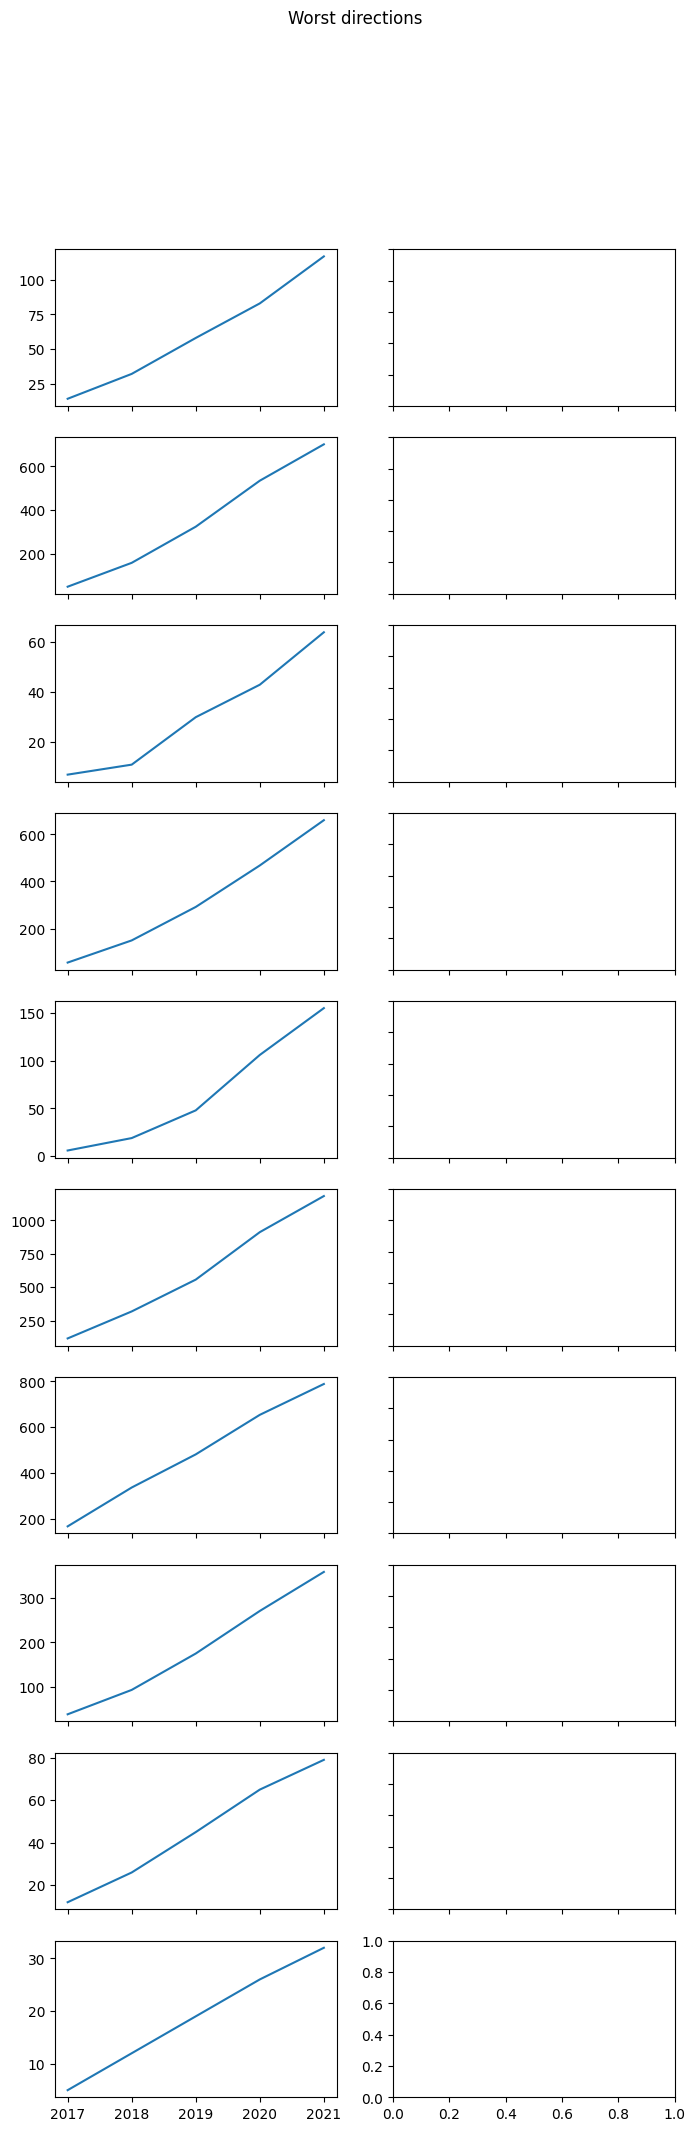

In [77]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(10,2, figsize=(8, 24))
fig.suptitle('Worst directions')

lows = []

def mu(x, L, x0, k):
    return 4 * np.exp(-k * (x - x0)) / ((1+np.exp(-k * (x - x0)))**2)

def logistic_function(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

for i,t in enumerate(sorted_topics2[-10:]):
    if t[0] not in progress_stat:    
        progress_stat[t[0]] = {}

    for y in range(2017,2022):
        if y not in progress_stat[t[0]]:
            progress_stat[t[0]][y] = 0

for i,t in enumerate(sorted_topics2[-10:]):
    years, vals = zip(*sorted(progress_stat[t[0]].items(),key=lambda x: x[0]))
    cum_vals = []
    last = 0
    for v in vals:
        last = v + last
        cum_vals.append(last)
    axs[i,0].plot(years, cum_vals)

    # initial_guess = [max(cum_vals), np.median(years), 1]
    # params, covariance = curve_fit(logistic_function, years, cum_vals, p0=initial_guess)
    # L_fit, x0_fit, k_fit = params
    

    # def func(L,x0,k):
    #     s = []
    #     for j in range(2017,2022):
    #         s.append(logistic_function(j, L, x0, k))
    #     return s   
    # axs[i,1].plot(years, func(L_fit, x0_fit, k_fit))
    # axs[i,1].set_title(str( mu(2021,L_fit, x0_fit, k_fit)) +" " + str(float(cum_vals[len(cum_vals) - 1])/(cum_vals[0]+0.001)))

    lows.append(float(cum_vals[len(cum_vals) - 1])/(cum_vals[0]+1)) 

    if i < 9:
        axs[i,0].label_outer()
        axs[i,1].label_outer()

In [78]:
mannwhitneyu(highs,lows,method="exact",alternative='greater')

MannwhitneyuResult(statistic=82.0, pvalue=0.007344822360302237)

## citations with cls

In [79]:
highs_cite = []

for i,t in enumerate(sorted_topics2[:10]):
    top_id = t[0]
    cites = topic2cites[top_id]
    avg_cites = np.asarray(cites).mean()
    highs_cite.append(avg_cites)

lows_cite = []

for i,t in enumerate(sorted_topics2[-10:]):
    top_id = t[0]
    cites = topic2cites[top_id]
    avg_cites = np.asarray(cites).mean()
    lows_cite.append(avg_cites)

mannwhitneyu(highs_cite,lows_cite,method="exact",alternative='greater')

MannwhitneyuResult(statistic=85.0, pvalue=0.0034207278789322136)

## Common phrases removed

In [9]:
import pickle
with open("ICLR2017_tops.pkl", 'rb') as f:
    tops = pickle.load(f)

In [10]:
from sentence_transformers import SentenceTransformer
import pickle

from tqdm import tqdm

from isanlp import PipelineCommon
from isanlp.simple_text_preprocessor import SimpleTextPreprocessor
from isanlp.processor_razdel import ProcessorRazdel
from isanlp.ru.processor_mystem import ProcessorMystem
from isanlp.ru.converter_mystem_to_ud import ConverterMystemToUd
from isanlp.processor_udpipe import ProcessorUDPipe


ppl = PipelineCommon([
  (SimpleTextPreprocessor(), ['text'],
   {'text': 'text'}),
  (ProcessorRazdel(), ['text'],
   {'tokens': 'tokens',
    'sentences': 'sentences'}),
  (ProcessorUDPipe(model_path = "/home/keen/.pyenv/versions/3.9.13/lib/python3.9/site-packages/ufal/russian-syntagrus-ud-2.5-191206.udpipe"), ['tokens', 'sentences'],
   {'lemma': 'lemma',
    'postag': 'postag',
    'syntax_dep_tree': 'syntax_dep_tree'}),
])

model = SentenceTransformer('all-MiniLM-L6-v2')

def find_root(dep_tree,offset):
    for i in range(offset, len(dep_tree)):
        if dep_tree[i].parent == -1:
            return i
    return -1  
    
def gather_tokens(root,sent,d,start,checked):
    tokens = []
    for i,s in enumerate(sent):
        if s.parent == root:
            if not (i+start in checked):
                checked[i+start] = True
                tokens.append([i+start,d])
                tokens += gather_tokens(i+start,sent,d+1,start,checked)  
    return tokens        

def serialize(sidx,root,isa, mind):
    tokens = sorted([(root,0)] + gather_tokens(root,isa['syntax_dep_tree'][sidx],1,isa['sentences'][sidx].begin,{}),key=lambda tup: tup[0])

    maxd = max([t[1] for t in tokens])
    serializations = []
    for d in range(maxd, mind,-1):
        text = []

        for t in tokens:
            if t[1] <= d: 
                text.append(isa['tokens'][t[0]].text)
        if len(text) > 4:# and len(text) < 13:        
            serializations.append(" ".join(text))        
    return serializations
    
def isa2gspan(isa):
   
    serializations = []
    for sidx,s in enumerate(isa['sentences']):
 
        offset = 0 

        while offset < s.end:
            root = find_root(isa['syntax_dep_tree'][sidx],offset)
            if root > -1:
                serializations += serialize(sidx, root, isa,0)
                offset = root + 1
            else:
                offset = s.end + 1
    return serializations    

In [11]:
#%load_ext autoreload
#%autoreload 2

import warnings
from scipy.spatial.distance import cosine
warnings.filterwarnings('ignore') 
    
from top2vec.Top2Vec.top2vec import Top2Vec

df = pd.read_excel("tp_2017conference.xlsx")
dat = []
dists = []

top2score = {}
for i, row in tqdm(df.iterrows()):
    rev_text = row["review"]
    res = ppl(rev_text)
    subclauses = isa2gspan(res)
    res = []
    score = 0
    for i,t in enumerate(tops):
        for sc in subclauses:
            vec = model.encode(sc)
            if cosine(vec, t[0]) < 0.2:     
                score += 1
    score  = np.sqrt(float(score) / (len(tops) * len(subclauses)))
    if score < 0.08:
        _,_,ts,tn = topic_model.query_topics(row["title"], 1)
        score = int(row['rate'][row['rate'].rfind("#")+1:row["rate"].rfind(":")])
        dists.append(ts[0])
        if tn[0] not in top2score:
            top2score[tn[0]] = []
        top2score[tn[0]].append(score)
    else:
        print("removed:", rev_text)



270it [3:42:34, 50.13s/it]

removed: This paper proposed a dynamic coattention network for the question answering task with long contextual documents. The model is able to encode co-dependent representations of the question and the document, and a dynamic decoder iteratively pointing the potential answer spans to locate the final answer. Overall, this is a well-written paper. Although the model is a bit complicated (coattention encoder, iterative dynamic pointering decoder and highway maxout network), the intuitions behind and the details of the model are clearly presented. Also the performance on the SQuAD dataset is good. I would recommend this paper to be accepted.


580it [8:20:16, 46.26s/it] 

removed: The paper analyses the misclassification error of discriminators and highlights the fact that while uniform probability prior of the classes makes sense early in the optimization, the distribution deviates from this prior significantly as the parameters move away from the initial values. Consequently, the optimized upper bound (log-loss) gets looser. As a fix, an optimization procedure based on recomputing the bound is proposed. The paper is well written. While the main observation made in this paper is a well-known fact, it is presented in a clear and refreshing way that may make it useful to a wide audience at this venue. I would like to draw the author*s attention to the close connections of this framework with curriculum learning. More on this can be found in [1] (which is a relevant reference that should be cited). A discussion on this could enrich the quality of the paper. There is a large body of work on directly optimizing task losses[2][3] and the references therein. 

587it [8:26:06, 40.45s/it]

removed: The main contribution of this paper is a construction to eps-approximate a piecewise smooth function with a multilayer neural network that uses O(log(1/eps)) layers and O(poly log(1/eps)) hidden units where the activation functions can be either ReLU or binary step or any combination of them. The paper is well written and clear. The arguments and proofs are easy to follow. I only have two questions: 1- It would be great to have similar results without binary step units. To what extent do you find the binary step unit central to the proof? 2- Is there an example of piecewise smooth function that requires at least poly(1/eps) hidden units with a shallow network?


589it [8:26:59, 32.51s/it]

removed: This paper proposes a new multiscale recurrent neural network, where each layer has different time scale, and the scale is not fixed but variable and determined by a neural network. The method is elegantly formulated within a recurrent neural network framework, and shows the state-of-the-art performance on several benchmarks. The paper is well written. Question) Can you extend it to bidirectional RNN?


736it [10:43:47, 45.07s/it]

removed: While it is interesting that this can be done, and it will be useful for some, it does seem like the audience is not really the mainstream ICLR audience, who will not be afraid to use a conventional ML toolkit. There is no new algorithm here, nor is there any UI/meta-design improvement to make it easier for non-experts to design and train neural network systems. I think there will be relatively little interest at ICLR in such a paper that doesn*t really advance the state of the art. I have no significant objection to the presentation or methodology of the paper.


908it [13:25:53, 53.96s/it]

removed: The authors propose a RNN-method for time-series classification with missing values, that can make use of potential information in missing values. It is based on a simple linear imputation of missing values with learnable parameters. Furthermore, time-intervals between missing values are computed and used to scale the RNN computation downstream. The authors demonstrate that their method outperforms reasonable baselines on (small to mid-sized) real world datasets. The paper is clearly written. IMO the authors propose a reasonable approach for dealing with missing values for their intended application domain, where data is not abundant and requires smallish models. I’m somewhat sceptical if the benefits would carry over to big datasets, where more general, less handcrafted multi-layer RNNs are an option.


1050it [15:38:49, 48.55s/it] 

removed: Unfortunately, even after reading the authors* response to my pre-review question, I feel this paper in its current form lacks sufficient novelty to be accepted to ICLR. Fundamentally, the paper suggests that traditional iterative algorithms for specific class of problems (ill-posed image inverse problems) can be replaced by discriminatively trained recurrent networks. As R3 also notes, un-rolled networks for iterative inference aren*t new: they*ve been used to replace CRF-type inference, and _also_ to solve image inverse problems (my refs [1-3]). Therefore, I*d argue that the fundamental idea proposed by the paper isn*t new---it is just that the paper seeks to *formalize* it as an approach for inverse problems (although, there is nothing specific about the analysis that ties it to inverse problems: the paper only shows that the RIM can express gradient descent over prior + likelihood objective). I also did not find the claims about benefits over prior approaches very compelli

1057it [15:43:13, 37.10s/it]

removed: This paper investigates the issue of whether and how to use syntactic dependencies in unsupervised word representation learning models like CBOW or Skip-Gram, with a focus one the issue of bound (word+dependency type, *She-nsubj*) vs. unbound (word alone, *She*) representations for context at training time. The empirical results are extremely mixed, and no specific novel method consistently outperforms existing methods. The paper is systematic and I have no major concerns about its soundness. However, I don*t think that this paper is of broad interest to the ICLR community. The paper is focused on a fairly narrow detail of representation learning that is entirely specific to NLP, and its results are primarily negative. A short paper at an ACL conference would be a more reasonable target.


1223it [18:17:37, 56.22s/it]

removed: This paper proposed a hardware accelerator for DNN. It utilized the fact that DNN are very tolerant to low precision inference and outperforms a state-of-the-art bit-parallel accelerator by 1.90x without any loss in accuracy while it is 1.17x more energy efficient. TRT requires no network retraining. It achieved super linear scales of performance with area. The first concern is that this paper doesn*t seem very well-suited to ICLR. The circuit diagrams makes it more interesting for the hardware or circuit design community. The second concern is the *take-away for machine learning community*, seeing from the response, the take-away is using low-precision to make inference cheaper. This is not novel enough. In last year*s ICLR, there were at least 4 papers discussing using low precision to make DNN more efficient. These ideas have also been explored in the authors* previous papers.


1386it [21:39:55, 38.28s/it] 

removed: This paper studies the problem of transfer learning in the context of domain adaptation. They propose to study it in the framework of knowledge distillation. Several settings are presented along with experiments on the Amazon Reviews dataset. The paper is nicely written and the problem studied is very important towards progress in AI. The results of the experiments could be improved but still justify the validity of applying distillation for transfer learning. Of course, the experimental setting is rather limited but the benchmarks are competitive enough to be meaningful. I had concerns regarding discussion of previous work but the extensive responses helped clarify this point (the authors should turn the arguments used in this thread into an appendix). I think this paper would make an interesting ICLR paper.


1409it [22:11:35, 40.46s/it] 

removed: The topic of the paper, model-based RL with a learned model, is important and timely. The paper is well written. I feel that the presented results are too incremental. Augmenting the frame prediction network with another head that predicts the reward is a very sensible thing to do. However neither the methodology not the results are novel / surprising, given that the original method of [Oh et al. 2015] already learns to successfully increment score counters in predicted frames in many games. I’m very much looking forward to seeing the results of applying the learned joint model of frames and rewards to model-based RL as proposed by the authors.


1435it [22:36:27, 47.98s/it]

removed: This paper proposes a variety of techniques for visualizing learned generative models, focussing specifically on VAE and GAN models. This paper is somewhat challenging to assess since it doesn*t propose a new algorithm, model, application etc. On the one hand these techniques will be highly relevant to the generative modeling community and I think this paper deserves a wide audience. The techniques proposed are simple, well explained, and of immediate use to those working on generative models. However, I*m not sure the paper is appropriate for an ICLR conference track as it doesn*t provide any greater theoretical insights into sampling generative models and there are no comparisons / quantitative evaluations of the techniques proposed. Overall, I*m very much on the fence since I think the techniques are useful and this paper should be read by those interested in generating modeling. I would be willing to increase my core if the author could present a case for why ICLR is an ap

1437it [22:38:36, 54.00s/it]

removed: In this paper the authors propose various techniques to sample visualizations from generative models with high dimensional latent spaces like VAEs and GANs. For example, the authors highlight the well known but often not sufficiently appreciated fact that the probability mass of high dimensional Gaussian distributions concentrates near a thin hyper-shell with a certain radius. They therefore propose to use spherical interpolations (great arcs) instead of the commonly used linear interpolations. In a similar spirit they propose a visualisation for analogies and techniques to reinforce structure in VAE latent spaces. I find it hard to give clear recommendation for this paper: On the one hand I enjoyed reading it and I might want use some of the proposals (e.g. spherical interpolations; J-diagrams) in future work of mine. On the other hand, it’s obvious that this paper is not a typical machine learning paper; it does not propose a new model, or training method, or provide (theore

1495it [23:28:01, 56.51s/it] 


In [12]:
sorted_topics = sorted([[t,np.asarray(top2score[t]).mean(),len(top2score[t])] for t in top2score if len(top2score[t]) > 9],key=lambda x: x[1],reverse=True)

In [13]:
sorted_topics

[[4, 6.882352941176471, 17],
 [26, 6.666666666666667, 21],
 [59, 6.615384615384615, 13],
 [84, 6.6, 15],
 [58, 6.393939393939394, 33],
 [45, 6.220588235294118, 68],
 [41, 6.17948717948718, 39],
 [57, 6.162162162162162, 37],
 [22, 6.055555555555555, 18],
 [14, 6.05, 20],
 [63, 6.0, 10],
 [64, 5.923076923076923, 13],
 [72, 5.839622641509434, 106],
 [21, 5.794520547945205, 73],
 [43, 5.7701149425287355, 87],
 [20, 5.75, 12],
 [27, 5.75, 24],
 [77, 5.732142857142857, 56],
 [36, 5.709677419354839, 31],
 [81, 5.690476190476191, 42],
 [30, 5.647058823529412, 34],
 [38, 5.617647058823529, 34],
 [25, 5.611111111111111, 18],
 [70, 5.571428571428571, 21],
 [40, 5.55, 20],
 [62, 5.55, 40],
 [75, 5.470588235294118, 34],
 [23, 5.4, 15],
 [11, 5.384615384615385, 39],
 [78, 5.384615384615385, 13],
 [46, 5.277777777777778, 18],
 [87, 5.260869565217392, 46],
 [86, 5.25, 36],
 [67, 5.0, 20],
 [83, 5.0, 13],
 [71, 4.935483870967742, 31],
 [51, 4.818181818181818, 33],
 [18, 4.791666666666667, 24],
 [55, 4.

# Get new topics

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from top2vec.Top2Vec.top2vec import Top2Vec
import pandas as pd

from scipy.stats import spearmanr


def SpearmanSim(topic_words1,topic_words2):
    all_words = set(topic_words1.tolist() + topic_words2.tolist())
    r1 = []
    r2 = []
    for w in all_words:
        r1_ = np.where(topic_words1 == w)[0]
        if len(r1_) == 0:
            r1_ = 100
        else:
            r1_ = r1_.sum()
        r1.append(r1_)
        r2_ = np.where(topic_words2 == w)[0]
        if len(r2_) == 0:
            r2_ = 100
        else:
            r2_ = r2_.sum()
        r2.append(r2_)  
    return spearmanr(r1,r2)

trh = 0.5    
prev_words = None
prev_scores = None
new_topics = {}
model = SentenceTransformer('all-MiniLM-L6-v2')
for year in range(2017,2021):
    rews = preprocess_reviews("tp_" + str(year) + "conference.xlsx")
    topic_model = Top2Vec(documents=rews["text"].to_list(),
                        ngram_vocab=True,
                        contextual_top2vec=True,speed="deep-learn",embedding_model="all-MiniLM-L6-v2",document_ids=rews["id"].to_list(),index_topics=False)

    topic_words, word_scores, topic_nums = topic_model.get_topics(topic_model.get_num_topics()) 
    
    if prev_words is not None:
        print("----------------------------------------------")
        for w,s in zip(topic_words, word_scores):
            found = False
            for old_w,old_s in zip(prev_words, prev_scores):
                dist, p_value = SpearmanSim(w,old_w)
                if dist > 0 and p_values < 0.05:
                    found = True   
            if not found:
                print("New topic:", w)
                if year not in new_topics:
                    new_topics[year] = []
                new_topics[year].append(w)    
            
    prev_words = topic_words
    prev_scores = word_scores
                

1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


2025-09-29 16:50:49,286 - top2vec - INFO - Pre-processing documents for training
/home/keen/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-09-29 16:50:49,344 - top2vec - INFO - Creating vocabulary embedding
Embedding vocabulary: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.26s/it]
2025-09-29 16:50:52,516 - top2vec - INFO - Create contextualized document embeddings
Embedding documents: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.23s/it]
102it [00:00, 9156.30it/s]
2025-09-29 16:50:58,562 - top2vec - INFO - Creating lower dimension embedding of documents
2025-09-29 16:5

1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


2025-09-29 17:00:14,794 - top2vec - INFO - Pre-processing documents for training
/home/keen/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-09-29 17:00:14,860 - top2vec - INFO - Creating vocabulary embedding
Embedding vocabulary: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.18s/it]
2025-09-29 17:00:17,871 - top2vec - INFO - Create contextualized document embeddings
Embedding documents: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.58s/it]
102it [00:00, 9277.02it/s]
2025-09-29 17:00:25,187 - top2vec - INFO - Creating lower dimension embedding of documents
2025-09-29 17:0

----------------------------------------------
[22, 37, 35, 13, 23, 29, 20, 11, 25, 28, 38, 43, 12, 30, 27, 17, 36, 7, 6, 5, 24, 16, 21, 3, 1, 2, 10, 39, 44, 41, 14, 18, 31, 9, 33, 8, 34, 15, 40, 0, 19, 26, 32, 4, 42] [22, 37, 35, 13, 23, 29, 20, 11, 25, 28, 38, 43, 12, 30, 27, 17, 36, 7, 6, 5, 24, 16, 21, 3, 1, 2, 10, 39, 44, 41, 14, 18, 31, 9, 33, 8, 34, 15, 40, 0, 19, 26, 32, 4, 42]
['adversarial divergences' 'gan training' 'transfer learning'
 'gradient normalization' 'neural networks' 'policy gradient'
 'reinforcement learning' 'machine learning' 'reward design'
 'active sensing' 'packet routing' 'networks openreview' 'this paper'
 'in practice' 'few shot' 'would be' 'at all' 'experiments are'
 'not clear' 'at least' 'better than' 'et al' 'does not' 'there are'
 'there any' 'have been' 'it seems' 'do not' 'show that'
 'proposed approach' 'paper presents' 'due to' 'can be' 'self play'
 'proposed method' 'number of' 'paper proposes' 'might be' 'based on'
 'the authors' 'state of' 's

1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84
